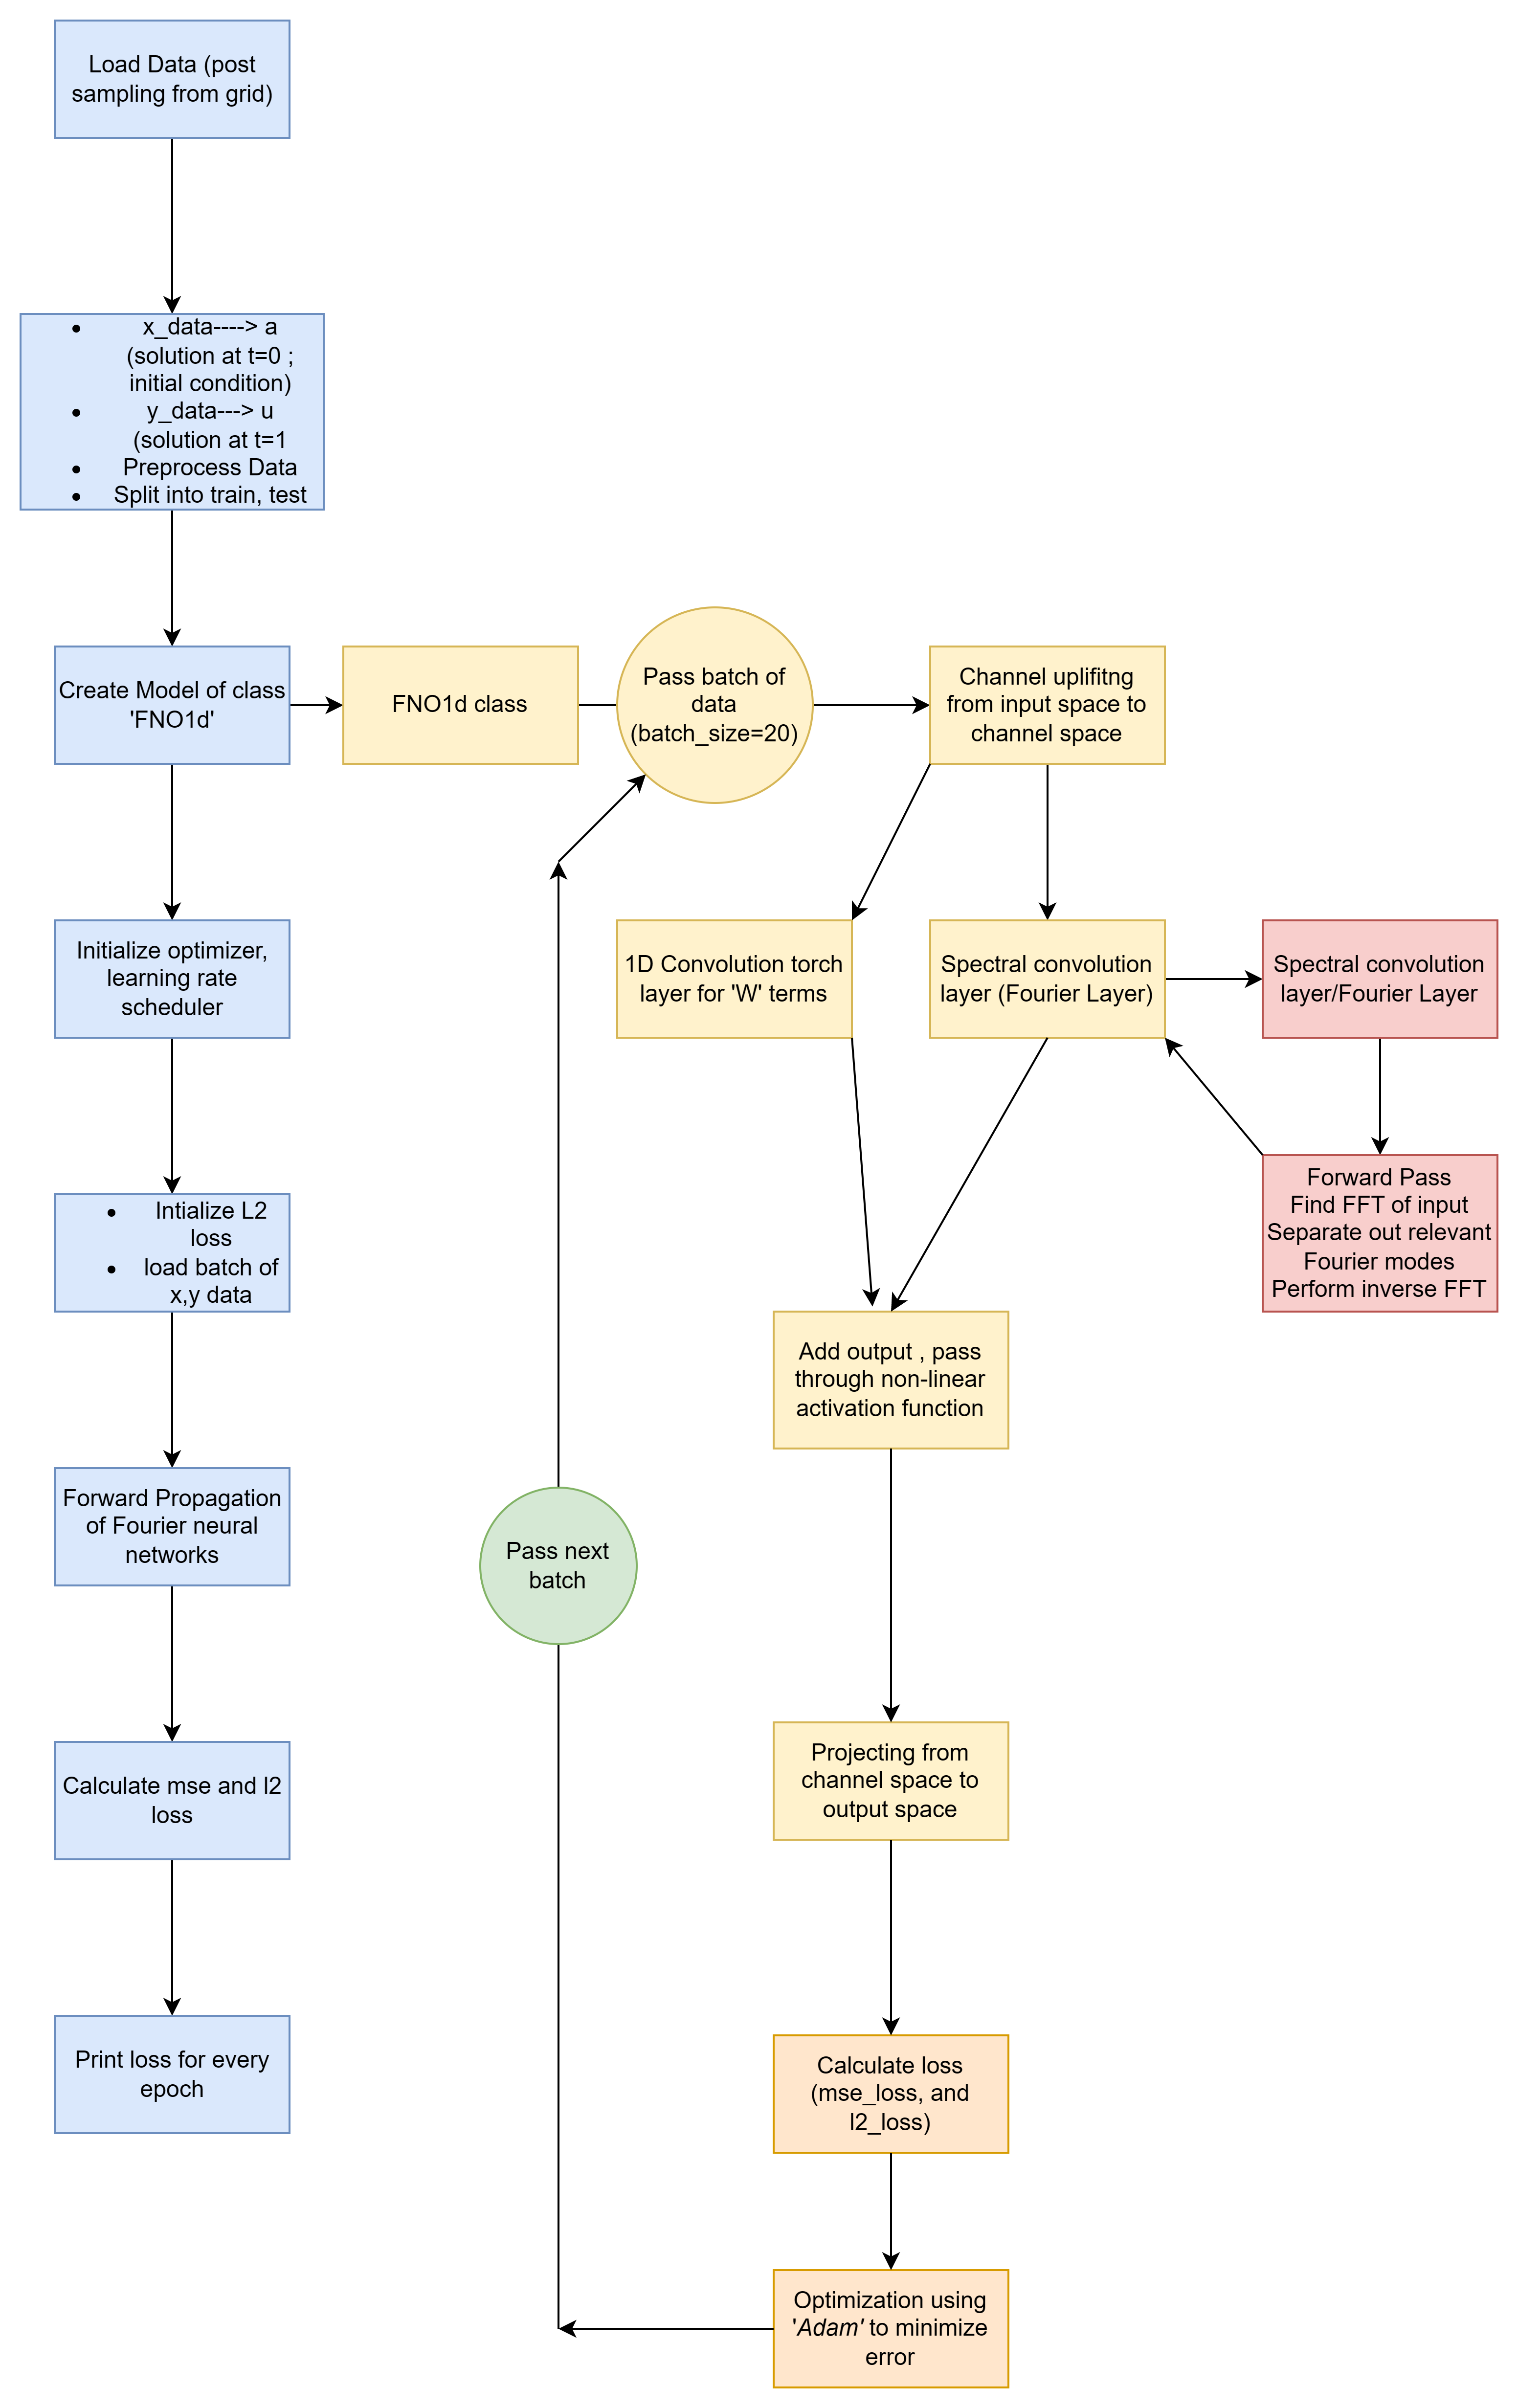

In [1]:
"""

This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import scipy
import operator
from functools import reduce
from functools import partial
from timeit import default_timer


import matplotlib.pyplot as plt


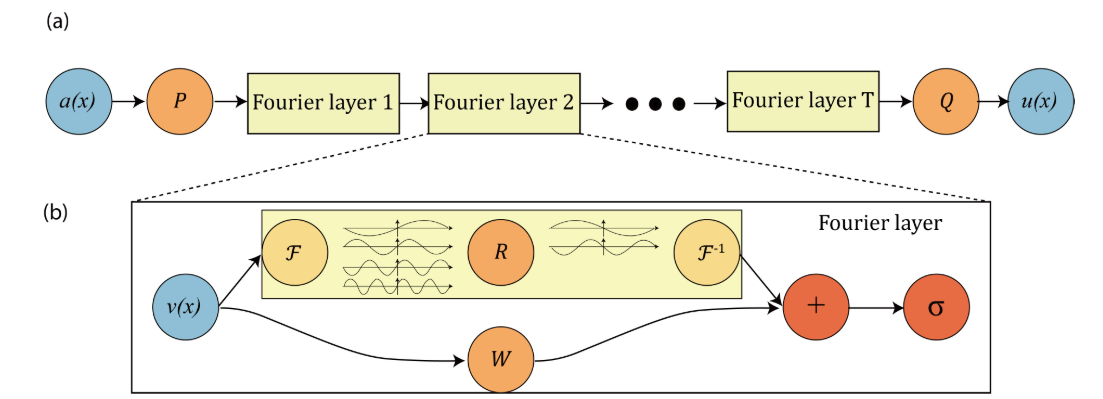

In [2]:
################################################################
#  1d fourier layer
################################################################

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        #use the scaling factor to initialise complex weights of dimensions [in_channels, out_channels, modes]

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        #do a complex multiplication of the form written above with truncated fourier modes and weights to do linear transformation 'R'
        #HINT : use 'torch.einsum'
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #HINT : you can use a torch function to do a fft of a real valued input 'x' so that output contains only positive frequencies
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)#call compl_mul1d function to enable linear transformation of selected modes and complex weights initiated above
        #print(out_ft)

        #Return to physical space
        x =  torch.fft.irfft(out_ft, n=x.size(-1)) #do an inverse fft of out_ft to shift from fourier space to real space using torch function
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 =  nn.Linear(2, self.width) # input channel is 2: (a(x), x); uplift from 2 features to 64 features using torch linear neural network

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv1 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv2 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv3 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.w0 = nn.Conv1d(self.width, self.width, 1)                               #bias term parallel to fourier layer of size (w), that do a 1D convolution
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 =  nn.Linear(self.width,128)                             #project from channel width to a 128 layer neural network (width, 128)
        self.fc2 = nn.Linear(128,1)                              #project from a 128 layer neural network to a single output neuron (128,1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)   #input now contains (a(x), x)
        x = self.fc0(x)                               #call fc0 layer initiated above to shift from 2 to 64 
        x = x.permute(0, 2, 1)   #permute layers to change order to allow for fft and linear transformation of x from (0,1,2)----> (0,2,1)
        

        x1 = self.conv0(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w0(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x)                        #pass through activation 'gelu'

        x1 = self.conv1(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w1(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x)

        x1 = self.conv2(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w2(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x) 

        x1 = self.conv3(x)
        x2 = self.w3(x)  
        x = x1 + x2     


        x = x.permute(0, 2, 1)     #permute back to original shape 
        x =    self.fc1(x)                    #uplift from channel width to 128 layer network
        x =    F.gelu(x)                 #pass through activation gelu
        x =     self.fc2(x)                    #shift to real space
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



In [3]:
class LpLoss(object):
    def __init__(self, p=2):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert p > 0
        self.p = p



    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms =  torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)#calculate norm between ground truth and predicted truth making sure their dimensions are compatible
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)#calculate norm of ground truth


        return torch.sum(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

In [4]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.0001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = scipy.io.loadmat('burgers_data_R10.mat')
x_data = dataloader['a'][:,::sub]
y_data = dataloader['u'][:,::sub]
x_data= x_data.astype(np.float32)
x_data= torch.from_numpy(x_data)
y_data= y_data.astype(np.float32)
y_data= torch.from_numpy(y_data)
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c
# model
model = FNO1d(modes, width)
print(count_params(model))


549569


In [10]:

################################################################
# training and evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)       #use Adam optimizer from torch with appropriate arguments 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)        # use a learning rate scheduler
train_mseList=[]
train_l2List=[]
myloss =  LpLoss() #initialise Lploss class object to calculate 'L2-norm'
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.reshape(batch_size, -1), y.reshape(batch_size, -1), reduction='mean') #calculate mse loss between forward pass of network and y data by reshaping out and y to be of compatible shapes
        l2 =  myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1)) #calculate L2-loss by calling the 'rel' function defined Lploss class
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        train_mseList.append(train_mse)
        train_l2List.append(train_l2)

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:

            out = model(x)
            test_l2 +=  myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1)).item() #calculate test L2 loss

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest


    print(ep, train_mse, train_l2, test_l2)

torch.save(model, 'ns_fourier_burgers')



549569
0 0.2169731655716896 0.9427632646560669 0.7286493015289307
1 0.04200692245736718 0.34718922996520996 0.22139829635620117
2 0.010150428805500268 0.15380734157562256 0.10729958295822144
3 0.003908937174128368 0.08318345737457275 0.06140739679336548
4 0.002034619859769009 0.052666164457798 0.04382882058620453
5 0.0013659302581800147 0.039329550504684445 0.03608323574066162
6 0.0010259556196979248 0.03297390297055244 0.03048050194978714
7 0.0009017170558217913 0.029880435913801195 0.026712986528873443
8 0.0007716608117334545 0.02600868073105812 0.02456966131925583
9 0.0006669087662885432 0.023521828770637514 0.02121519446372986
10 0.0005831099819624797 0.021182464659214018 0.019047965705394746
11 0.0005084957563667558 0.019609978824853897 0.018153875470161437
12 0.0004343956623779377 0.018207487985491752 0.017071363031864167
13 0.0003887133892567363 0.01684454394876957 0.014825904667377472
14 0.0003369387731436291 0.015294196337461471 0.014185641258955002
15 0.00030030960602744016 0

122 1.2606551105136531e-05 0.0032923367135226727 0.0030245450884103776
123 1.2292644479430237e-05 0.0033594004474580288 0.003417171500623226
124 1.1927824614303972e-05 0.0031472997292876243 0.0029043226689100267
125 1.2105893033549364e-05 0.003171549156308174 0.0033101479336619375
126 1.2265354640703663e-05 0.003441740896552801 0.003130417093634605
127 1.1444440193599803e-05 0.0033377019315958024 0.0034681586176156997
128 1.2047384386733028e-05 0.0032681035287678243 0.0029972915351390837
129 1.1497998175400425e-05 0.003292944710701704 0.003544261418282986
130 1.1966710145543402e-05 0.0034533567652106287 0.003148101344704628
131 1.1073760384761045e-05 0.0031825220957398415 0.003405585549771786
132 1.1147281394414677e-05 0.003509920932352543 0.0031765273213386538
133 1.1467720871678467e-05 0.003507488876581192 0.003168194070458412
134 1.0707391058986104e-05 0.0031176724322140217 0.0030627415329217912
135 1.0240596293442649e-05 0.0030040917843580247 0.0033749548718333246
136 1.08023351026

241 4.78399058465584e-06 0.002715361729264259 0.0024204334989190103
242 4.8068971386783235e-06 0.0026676315255463124 0.00302933719009161
243 4.212329778283674e-06 0.002067166255787015 0.0022602350264787673
244 4.008584642178903e-06 0.001998344359919429 0.0020133448019623757
245 4.003902459430719e-06 0.0019876680467277763 0.001817322187125683
246 3.9337548366802365e-06 0.0019312723223119973 0.0018396758660674094
247 4.18770620910891e-06 0.0021712634973227976 0.0019046047888696194
248 3.9944122073620746e-06 0.001963605402037501 0.0018362435698509216
249 3.9630331843909515e-06 0.0020028261709958313 0.0018873908743262291
250 3.83464718538562e-06 0.0019194487649947405 0.0017755292728543282
251 3.991359679389461e-06 0.00200576651096344 0.002017602473497391
252 3.816124828972533e-06 0.001886419229209423 0.0018203267082571983
253 3.876446368167308e-06 0.0018917427267879248 0.001793573945760727
254 4.109958743470088e-06 0.0023405122980475427 0.00307354386895895
255 4.321739943975444e-06 0.00239

359 2.537019877024704e-06 0.0013722815718501806 0.0014179939217865466
360 2.51741023419072e-06 0.0013460166584700346 0.001400091964751482
361 2.5389618500071266e-06 0.0013771982714533807 0.0013503468595445155
362 2.5125461917241408e-06 0.0014353699274361133 0.0013521257415413856
363 2.5143443946262776e-06 0.00132953817024827 0.0013685321062803268
364 2.4674029660332052e-06 0.0013297507781535388 0.0013532388024032117
365 2.510962949884288e-06 0.0013380187842994928 0.0013797410391271114
366 2.5205927877891554e-06 0.001416640367358923 0.001360222063958645
367 2.493268343926047e-06 0.001330369735136628 0.0013355826213955879
368 2.4792685672991866e-06 0.0013831817619502544 0.0013658176735043526
369 2.520028709511735e-06 0.001370194811373949 0.0013035043701529502
370 2.4375734236059543e-06 0.0013229924216866494 0.0013551090285182
371 2.506433193332214e-06 0.0013402484208345413 0.0013652809523046017
372 2.4354073309496016e-06 0.001323541134595871 0.0013512428291141986
373 2.477626737800165e-0

476 2.2132536822994096e-06 0.0011291667958721518 0.001176690049469471
477 2.208757433095343e-06 0.0011291891019791366 0.0011701915413141251
478 2.209196255620327e-06 0.0011287766881287098 0.0011715702712535858
479 2.2124487627195323e-06 0.0011265741772949695 0.0011775337532162666
480 2.2116972195362906e-06 0.0011278481343761086 0.001168499644845724
481 2.2076361999268103e-06 0.0011258708070963621 0.0011692937649786473
482 2.2089607459463422e-06 0.0011258683502674103 0.0011680421233177184
483 2.208069972056137e-06 0.0011251765601336956 0.0011685145646333694
484 2.2089074278142105e-06 0.0011248734192922712 0.0011717835068702697
485 2.207670454907884e-06 0.001125857040286064 0.0011694267392158507
486 2.2049994218775735e-06 0.0011240689903497696 0.001168256290256977
487 2.2059729271006744e-06 0.0011244498267769813 0.0011680250056087971
488 2.205655106024551e-06 0.0011239591035991908 0.0011676010303199292
489 2.207431431315854e-06 0.0011238016430288552 0.001167722549289465
490 2.20815241988

FileNotFoundError: [Errno 2] No such file or directory: 'model/ns_fourier_burgers'

In [11]:
torch.save(model, 'ns_fourier_burgers')

Relative L2 Loss for Training data is:  0.001121675729751587 
Relative L2 Loss for Testing data is:   0.0011675482988357543
MSE Loss for Training data is:  2.2051251562515972e-06 
MSE Loss for Testing data  1.6715783885956625e-06
RMSE Error for Training data is:  0.0014849663821957712 
RMSE Error for Testing data  0.0012928953509838538
Training data plots are like:
Testing data plots are like:


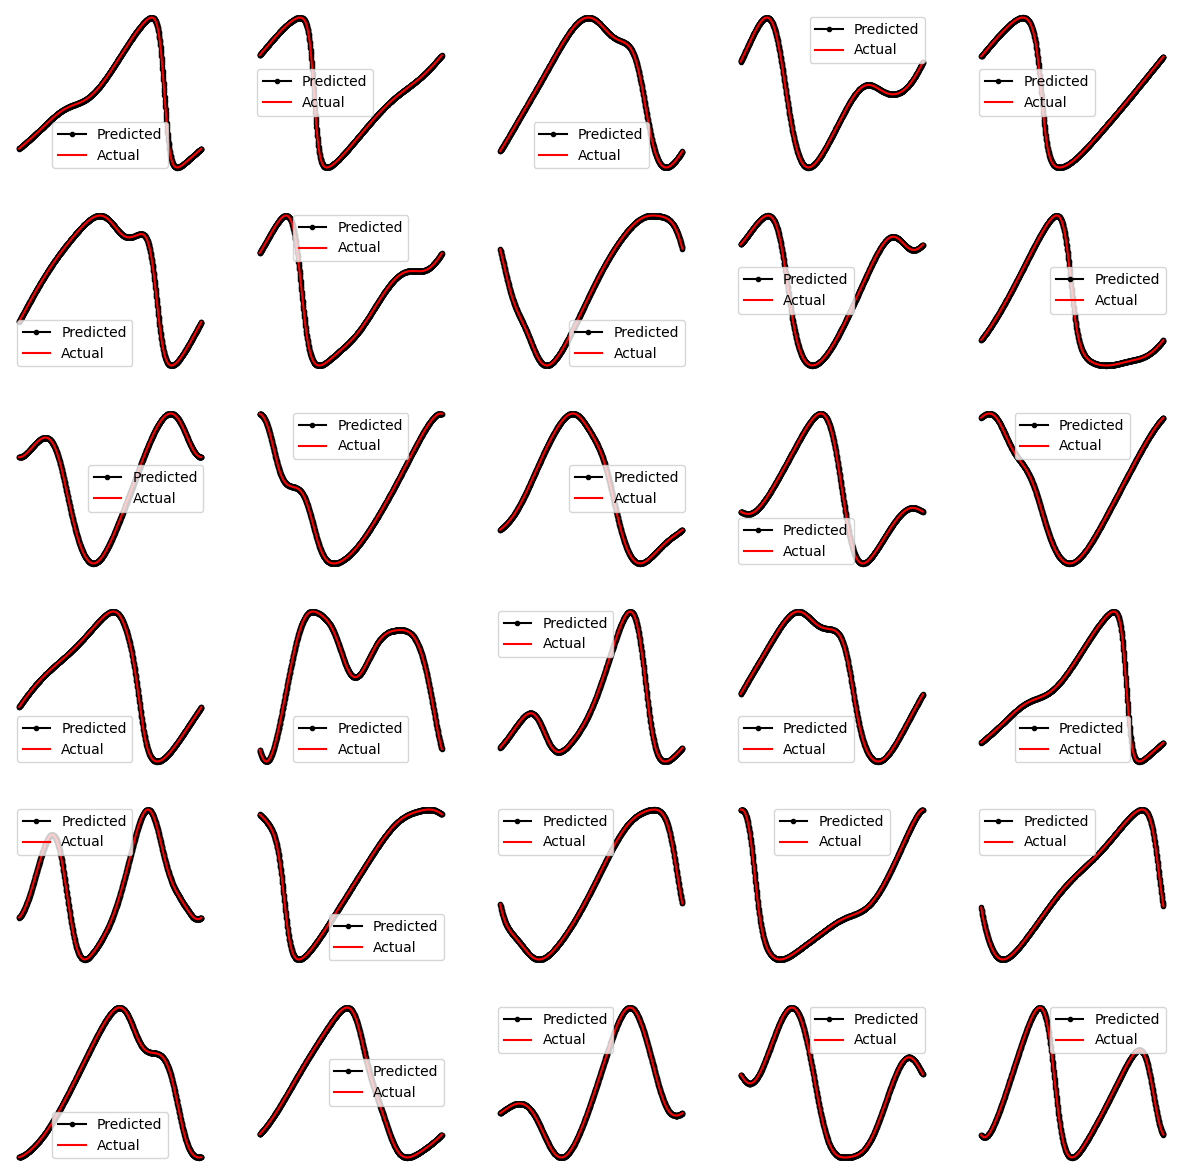

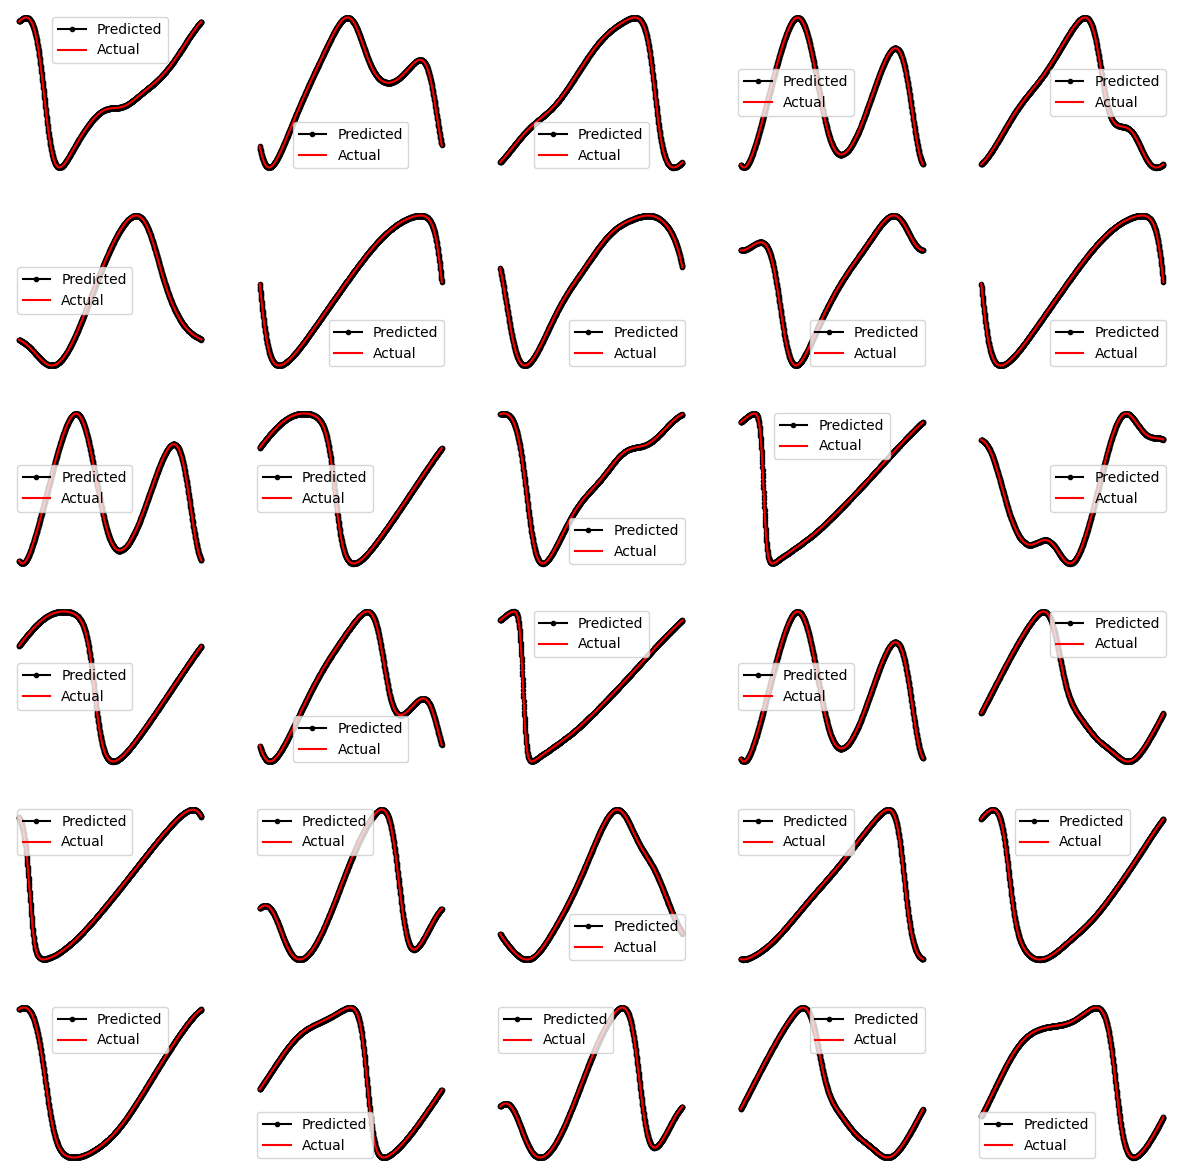

In [5]:
# Load the saved model
model = torch.load('ns_fourier_burgers')

# Set the model to evaluation mode
model.eval()

train_y = y_train.flatten()
test_y = y_test.flatten()

train_pred = model(x_train)
test_pred = model(x_test)

myloss =  LpLoss() #initialise Lploss class object to calculate 'L2-norm'
train_err = myloss(y_train,train_pred).item()/1000
test_err = myloss(y_test,test_pred).item()/100

train_err,test_err

print("Relative L2 Loss for Training data is: ",train_err , "\nRelative L2 Loss for Testing data is:  ",test_err)

# Calculate mean squared error
mse_train = torch.mean((train_pred.flatten() - train_y)**2).item()
mse_test = torch.mean((test_pred.flatten() - test_y)**2).item()
print("MSE Loss for Training data is: ",mse_train , "\nMSE Loss for Testing data ",mse_test)
# Calculate root mean squared error
rmse_train = np.sqrt(mse_train)
rmse_test= np.sqrt(mse_test)
print("RMSE Error for Training data is: ",rmse_train , "\nRMSE Error for Testing data ",rmse_test)

fig = plt.figure(figsize=(15,15))
print("Training data plots are like:")
for i in range(30):  
    r = np.random.choice(x_train.shape[0])
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(train_pred.detach().numpy()[r],c = 'black', marker='.',label="Predicted")  
    ax.plot(y_train.detach().numpy()[r], c='r',label="Actual")
    plt.legend()
    plt.axis('off')

fig = plt.figure(figsize=(15,15))
print("Testing data plots are like:")
for i in range(30):  
    r = np.random.choice(x_test.shape[0])
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(test_pred.detach().numpy()[r],c = 'black', marker='.',label="Predicted")  
    ax.plot(y_test.detach().numpy()[r], c='r',label="Actual")
    plt.legend()
    plt.axis('off')